In [1]:
import sys
sys.path.append('/global/homes/a/arosado/LSSutils/')

from lssutils.lab import get_meandensity
from lssutils.dataviz import mollview

In [2]:
#import sys
sys.path.append("/global/homes/a/arosado/")
from prepare_data import prepare_LRGmock_data, maps_dr9, hpixsum
from astropy.table import Table, vstack

import os
import utils as ut
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

In [3]:
cscratch = os.getenv('CSCRATCH')
base_dir = os.path.join(cscratch, 'test_sysnet')
cont_mocks_tables_dir = os.path.join(base_dir, 'contaminated_mocks_tables')
plot_dir = ''

In [4]:
nside=256
ph = 0 

# read data used for NN
#mock_cont_old = Table.read(f'/global/cscratch1/sd/arosado/test_sysnet/prepared_contaminated_mocks/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph{ph:003d}.fits')
mock_dir = os.path.join(cont_mocks_tables_dir, f'cutsky_LRG_z0.800_AbacusSummit_base_c000_ph{ph:003d}')
mock_cont_fn = os.path.join(mock_dir, f'cutsky_LRG_z0.800_AbacusSummit_base_c000_ph{ph:003d}.fits')
mock_cont = Table.read(mock_cont_fn)

# get NN-weights
#npred_old = hp.read_map(f'/global/cscratch1/sd/arosado/test_sysnet/prepared_contaminated_mocks/windows_clean/nn-weights.hp256.fits')
nn_table = Table.read(f'{mock_dir}/nn-weights.fits')
npred = ut.make_hp(np.mean(nn_table['weight'],axis=1), nn_table['hpix'], nside)

# read systematics
concat_sysm = vstack([Table.read(f'{cscratch}/rands/rongpu_imaging_maps/pixmap_{r}_nside_256_minobs_1_maskbits_1111213.fits', format='fits') for r in ['north','south']])

In [24]:
#[np.mean(nn_table['weight'], axis=1)[i] for i in range(25)], [nn_table['weight'][i].mean() for i in range(25)]

In [6]:
%%time

norm_method = 'mean'
downsampling= 'frac'
selection = dict(main=0, nz=0, Y5=1, sv3=0)
# get uncontaminated mock and contaminated mock (contaminated mock by downsampling), and project them to healpix maps
mock_null, mock_null_pix_number = ut.get_mock(contaminated=False, selection_fn=None, nside=nside, norm_method=norm_method, downsampling='mean',
                                                  tracer='LRG', ph=ph, return_hpix=True, **selection)
mock_null_hmap = ut.project2hp(nside, mock_null)

# collect randoms
randoms_path = '/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_random_S1000_1X.fits'
randoms = ut.apply_mock_mask(randoms_path, **selection)

using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=0, nz=0, Y5=1, sv3=0
applying mask: main=0, nz=0, Y5=1, sv3=0
CPU times: user 24.5 s, sys: 11.3 s, total: 35.8 s
Wall time: 57 s


In [7]:
m_null = ut.make_hp(mock_null_hmap[mock_null_pix_number],  mock_null_pix_number, nside)
m_cont = ut.make_hp(mock_cont['label'], mock_cont['hpix'], nside)

In [8]:
print(np.percentile(m_null[m_null>0], [0,1,99,100]), np.percentile(m_cont[m_cont>0], [0,1,99,100]), np.percentile(npred[npred>0], [0,1,99,100]))

[  1. 108. 260. 348.] [ 1. 11. 46. 72.] [19.392296   21.61467548 24.14937894 28.27436873]


In [7]:
print(np.percentile(m_null[m_null>0], [0,1,99,100]), np.percentile(m_cont[m_cont>0], [0,1,99,100]), np.percentile(npred[npred>0], [0,1,99,100]))

[  1. 108. 260. 348.] [ 1. 11. 46. 69.] [19.392296   21.61467548 24.14937894 28.27436873]


In [9]:
c = ut.make_hp(mock_cont['fracgood']/mock_cont['label'], mock_cont['hpix'], nside)
c = npred*c
np.percentile(c[c>0], [0,1,99,100])

/tmp/ipykernel_21074/2955488508.py:1: RuntimeWarning: divide by zero encountered in divide
  c = ut.make_hp(mock_cont['fracgood']/mock_cont['label'], mock_cont['hpix'], nside)
/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


array([0.03903368, 0.49338643, 1.94996035,        nan])

In [10]:
t = m_cont/m_null
np.percentile(t[t>0], [0,1,99,100])

array([0.01587302, 0.07017544, 0.24074074, 1.        ])

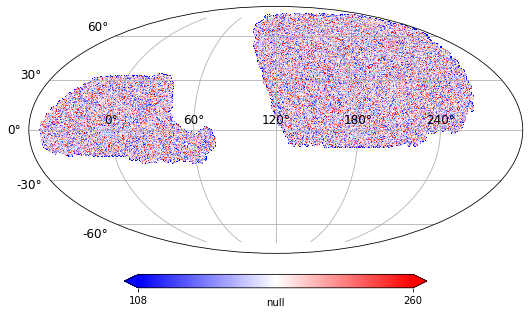

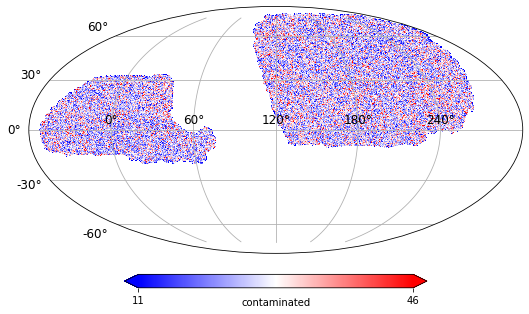

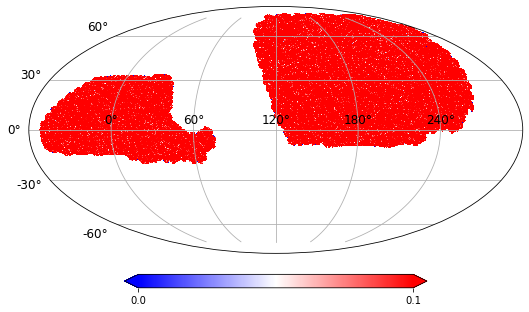

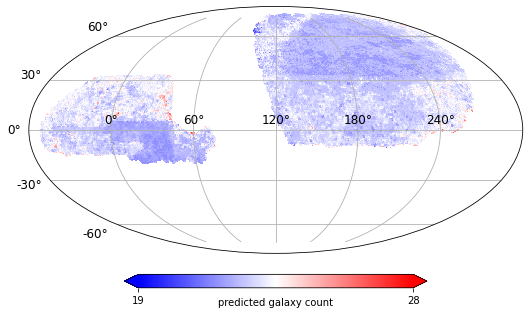

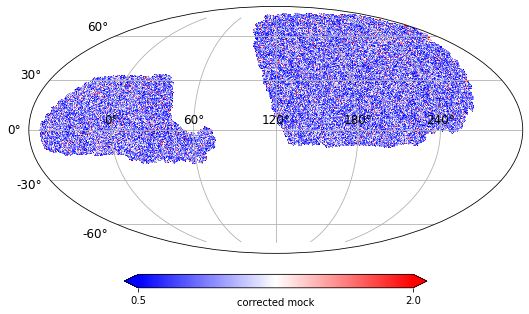

In [11]:
mollview(m_null, 108, 260, 'null', colorbar=True)
mollview(m_cont, 11, 46, 'contaminated', colorbar=True)
mollview(t, 0.,.1, '', colorbar=True)
mollview(npred, 19, 28, 'predicted galaxy count', colorbar=True)
mollview(c, 0.5, 2., 'corrected mock', colorbar=True)

In [12]:
%%time
#maps =['STARDENS', 'EBV',
#       'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z',
#       'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z',
#       'PSFDEPTH_W1', 'PSFDEPTH_W2'] 
maps = maps_dr9
systematics = concat_sysm #edmond_sysm
hp_order = 'ring' # hpix ordering used in systematics file
zmin, zmax = 0., 6.
 
def mock_meandensity(mock, randoms, systematics, hp_order, maps, zmin=zmin, zmax=zmax, nside=256, selection_fn=None, binning='equi-area',
                    njack=20):
    
    prep_data = prepare_LRGmock_data(mock, randoms, systematics, hp_order=hp_order, zmin=zmin, zmax=zmax, nside=nside, columns=maps)
    ngal = prep_data['label']
    nran = prep_data['fracgood']
    mask = np.ones_like(prep_data['label'], '?')
    sysm = prep_data['features']
    #hpix = prep_data['hpix']

    nnbar_list = get_meandensity(ngal, nran, mask, sysm, 
                                 columns=maps, selection_fn=selection_fn, binning=binning, percentiles=[1, 99],
                                 global_nbar=True, njack=njack)
    return nnbar_list, prep_data


#nnbar_list = get_meandensity(ngal, nran, mask, sysm, 
#                             columns=maps, selection_fn=None, binning='equi-area', percentiles=[1, 99],
#                             global_nbar=True, njack=20)

nnbar_list_null, prep_data_null = mock_meandensity(mock_null, randoms, systematics, hp_order, maps)

.............preparing randoms
cleaning randoms
preparing data
cleaning data
CPU times: user 44.3 s, sys: 3.82 s, total: 48.1 s
Wall time: 48.1 s


In [19]:
%%time

maps = maps_dr9
 
def get_nnbar(prep_data, maps, nside=256, selection_fn=None, binning='equi-area',njack=20):
   
    ngal = prep_data['label']
    nran = prep_data['fracgood']
    mask = np.ones_like(prep_data['label'], '?')
    sysm = prep_data['features']
    if selection_fn is not None:
        hpix = prep_data['hpix']
        selection_fn = selection_fn[hpix]
    print('computing nnbar')
    nnbar_list = get_meandensity(ngal, nran, mask, sysm, 
                                 columns=maps, selection_fn=selection_fn, binning=binning, percentiles=[1, 99],
                                 global_nbar=True, njack=njack)
    return nnbar_list

nnbar_list_uncont = get_nnbar(mock_cont, maps, selection_fn=npred)
#nnbar_list_cont = get_nnbar(mock_cont, maps)

computing nnbar


AssertionError: 'selection_mask' must be > 0

In [15]:
%%time
npred_normed = ut.normalize_selection_func(npred, norm_method='mean')
#nnbar_list_uncont_normed = get_nnbar(mock_cont, maps, selection_fn=npred_normed)

contamination using mean
CPU times: user 8.33 ms, sys: 4.2 ms, total: 12.5 ms
Wall time: 9.61 ms


In [16]:
np.percentile(npred_normed[npred_normed>0], [0,1,99,100])

array([0.85573535, 0.95380361, 1.06565397, 1.24767985])

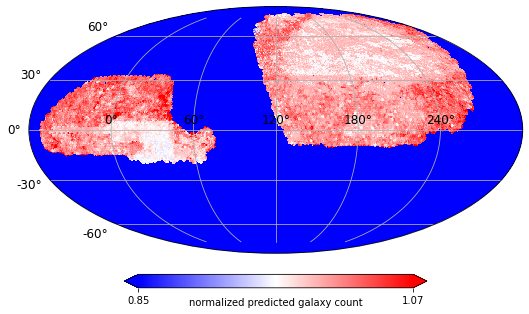

In [17]:
mollview(npred_normed, 0.85,1.07, 'normalized predicted galaxy count', colorbar=True)

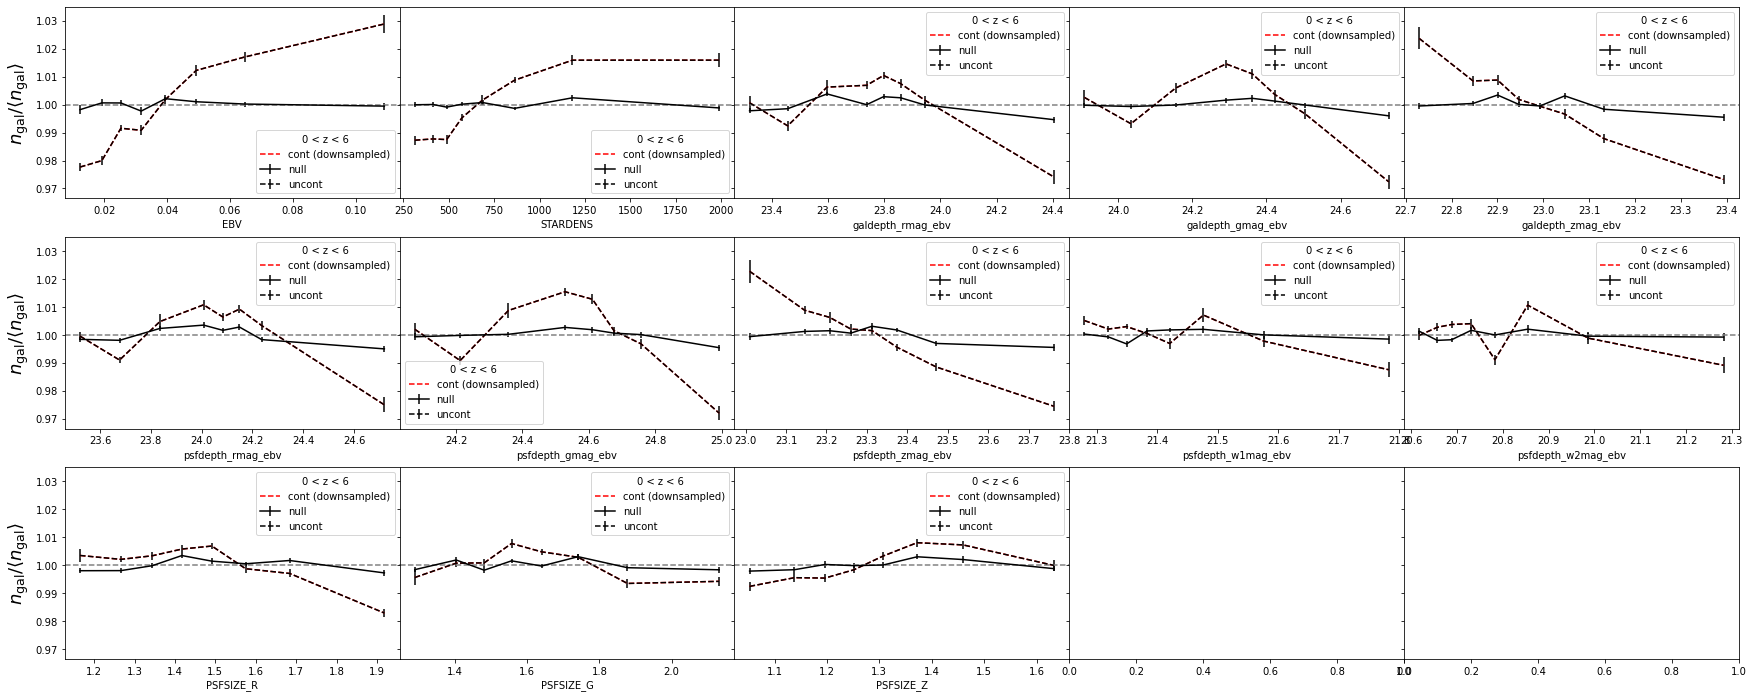

CPU times: user 2.64 s, sys: 420 ms, total: 3.06 s
Wall time: 2.83 s


In [18]:
%%time
zmin, zmax = 0, 6 
fg, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 12), sharey=True)
fg.subplots_adjust(wspace=0.0, hspace=0.2)
plt.rc('figure', facecolor='w')
ax = ax.flatten()
ftsize=18

for col_i in range(len(maps)):
    ax[col_i].set(xlabel=f'{maps[col_i]}')
    ax[col_i].errorbar(nnbar_list_null[col_i]['bin_avg'], nnbar_list_null[col_i]['nnbar'], nnbar_list_null[col_i]['nnbar_err'], color='k', label='null')
    #ax[col_i].errorbar(nnbar_list_uncont_normed[col_i]['bin_avg'], nnbar_list_uncont_normed[col_i]['nnbar'], nnbar_list_uncont_normed[col_i]['nnbar_err'], ls='--', color='k', marker='o',
    #                   label='uncont(normed)')
    ax[col_i].errorbar(nnbar_list_uncont[col_i]['bin_avg'], nnbar_list_uncont[col_i]['nnbar'], nnbar_list_uncont[col_i]['nnbar_err'], ls='--', color='k', label='uncont')
    ax[col_i].plot(nnbar_list_cont[col_i]['bin_avg'], nnbar_list_cont[col_i]['nnbar'], color='r',ls='--', label='cont (downsampled)')
    ax[col_i].legend(title=f'{zmin} < z < {zmax}')
    ax[col_i].axhline(y=1., color='gray', ls='--')
ax[0].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
ax[5].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
ax[10].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
#ax[0].set_ylim(1.00-0.2, 1.00+0.2)
fn = os.path.join(plot_dir, f'LRG_density_variations_mitigated_mocks_ph{ph:003d}.png')
#plt.savefig(fn, facecolor='white',bbox_inches='tight', pad_inches=0.1, dpi=200)

plt.show()

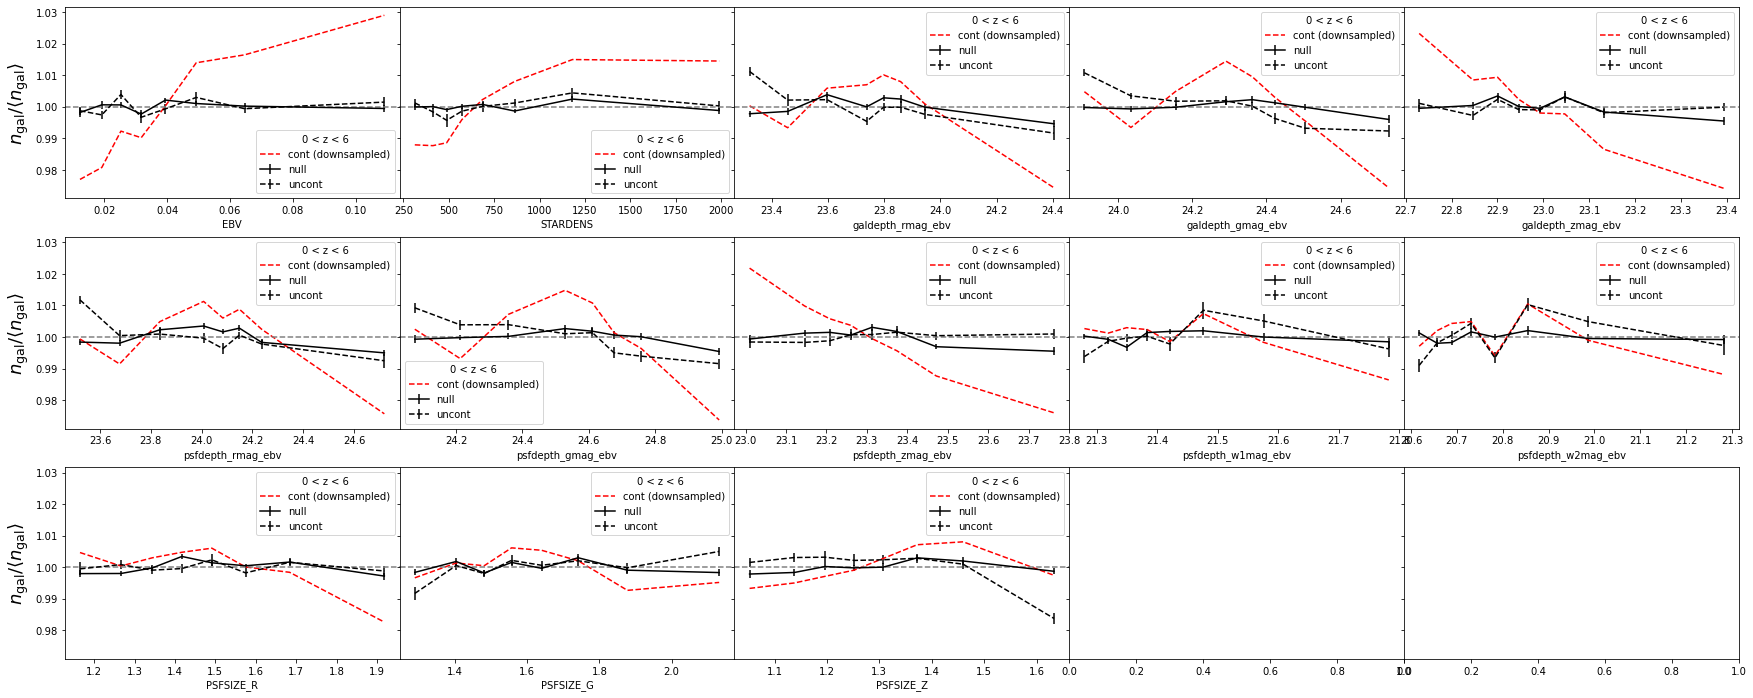

CPU times: user 4.9 s, sys: 948 ms, total: 5.85 s
Wall time: 5.46 s


In [25]:
%%time
zmin, zmax = 0, 6 
fg, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 12), sharey=True)
fg.subplots_adjust(wspace=0.0, hspace=0.2)
plt.rc('figure', facecolor='w')
ax = ax.flatten()
ftsize=18

for col_i in range(len(maps)):
    ax[col_i].set(xlabel=f'{maps[col_i]}')
    ax[col_i].errorbar(nnbar_list_null[col_i]['bin_avg'], nnbar_list_null[col_i]['nnbar'], nnbar_list_null[col_i]['nnbar_err'], color='k', label='null')
    #ax[col_i].errorbar(nnbar_list_uncont_normed[col_i]['bin_avg'], nnbar_list_uncont_normed[col_i]['nnbar'], nnbar_list_uncont_normed[col_i]['nnbar_err'], ls='--', color='k', marker='o',
    #                   label='uncont(normed)')
    ax[col_i].errorbar(nnbar_list_uncont[col_i]['bin_avg'], nnbar_list_uncont[col_i]['nnbar'], nnbar_list_uncont[col_i]['nnbar_err'], ls='--', color='k', label='uncont')
    ax[col_i].plot(nnbar_list_cont[col_i]['bin_avg'], nnbar_list_cont[col_i]['nnbar'], color='r',ls='--', label='cont (downsampled)')
    ax[col_i].legend(title=f'{zmin} < z < {zmax}')
    ax[col_i].axhline(y=1., color='gray', ls='--')
ax[0].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
ax[5].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
ax[10].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
#ax[0].set_ylim(1.00-0.2, 1.00+0.2)
fn = os.path.join(plot_dir, f'LRG_density_variations_mitigated_mocks_ph{ph:003d}.png')
#plt.savefig(fn, facecolor='white',bbox_inches='tight', pad_inches=0.1, dpi=200)

plt.show()

In [44]:
randoms['RA'].size

51850233

In [48]:
mock_null['RA'].size

51834419

In [49]:
len(mock_cont)

283508

In [51]:
selection = dict(main=1, Y5=1, nz=0, sv3=0)
randoms_main = ut.apply_mock_mask(randoms_path, **selection)

applying mask: main=1, nz=0, Y5=1, sv3=0


In [52]:
randoms_main['RA'].size

9054011

In [54]:
# get NN-weights
nn_test1 = hp.read_map(f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean_test1/nn-weights.hp256.fits')

mock_cont, mock_cont_pix_number = ut.get_mock(contaminated=True, selection_fn=nn_test1, nside=nside, norm_method=norm_method, downsampling=downsampling,
                                              tracer='LRG', ph=0, main=0, nz=0, Y5=1, sv3=0, return_hpix=True)

/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 256
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=0, nz=0, Y5=1, sv3=0
contaminating mock
contamination using mean
using frac when downsampling


In [55]:
mock_cont['RA'].size

7455452